In [75]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

np.random.seed(23)

# 2.

### Step 1: Encoding x value in Binary Number

Since we are considering 1-digit precision of fraction decimal $x$, we compute

$$\lceil\log_2((\textrm{upper_bound} - \textrm{lower_bound})\cdot 10^1)\rceil = \lceil\log_2(4\cdot 10)\rceil = 6.$$

So, we are going to need 6Bits for the chromosome.

The decoding equation from binary to decimal is as follows:

$$x = -2 + \textrm{BIN2DEC(chromosome)}\cdot(2-(-2))/(2^6 - 1) = -2 + \textrm{BIN2DEC(chromosome)}\cdot 4/63.$$

## Step 2: Choosing population size

As we have six Bits/genes in chromosome, our population size will be $1.5\cdot 6 = 9\rightarrow 10.$ (we need an even number)

Now we randomly select 10 chromosomes from $[0, 2^6-1]$, obtaining:

In [2]:
chromosomes = np.random.randint(2**6, size=10)
chromosomes

array([19, 38, 40,  9, 54, 40, 31, 45, 12, 27])

In [3]:
chroms_bin = [bin(chrom)[2:] for chrom in chromosomes]
chroms_bin

['10011',
 '100110',
 '101000',
 '1001',
 '110110',
 '101000',
 '11111',
 '101101',
 '1100',
 '11011']

In [4]:
def decode(chrom):
    return round(-2 + chrom*(4/63.), 6)

In [5]:
decoded_vals = [decode(chrom) for chrom in chromosomes]
decoded_vals

[-0.793651,
 0.412698,
 0.539683,
 -1.428571,
 1.428571,
 0.539683,
 -0.031746,
 0.857143,
 -1.238095,
 -0.285714]

In [6]:
population_df = pd.DataFrame()
population_df['Chromosomes'] = chromosomes
population_df['Binary Representation'] = chroms_bin
population_df['Decoded Value'] = decoded_vals
population_df

,Chromosomes,Binary Representation,Decoded Value
0,19,10011,-0.793651
1,38,100110,0.412698
2,40,101000,0.539683
3,9,1001,-1.428571
4,54,110110,1.428571
5,40,101000,0.539683
6,31,11111,-0.031746
7,45,101101,0.857143
8,12,1100,-1.238095
9,27,11011,-0.285714


## Step 3: Choosing the fitness function

Since we are maximizing our starting function, we use it as a fitness function as well. So, 

$$\textrm{Fitness}(x) = e^{-x^2} + 0.01\cos(200x),$$

where $x\in[-2, 2]$.

## Step 4: Selection by Roulette Wheel

In [7]:
def fitness(x):
    return round(np.exp(-x**2) + .01*np.cos(200*x), 6)

In [8]:
fitness_vals = [fitness(x) for x in decoded_vals]
fitness_vals

[0.531858,
 0.849933,
 0.751658,
 0.120068,
 0.120068,
 0.751658,
 1.008971,
 0.47755,
 0.207477,
 0.929897]

For our case we select $C_\min = -0.5$, and we have 

$$F(x) = f(x) + C_\min,\qquad f(x) + C_\min > 0,$$
and $F(X) = 0$, otherwise.

In [9]:
F = [round(max(fit_val - .5, 0), 6) for fit_val in fitness_vals]
F

[0.031858, 0.349933, 0.251658, 0, 0, 0.251658, 0.508971, 0, 0, 0.429897]

In [10]:
population_df['Fitness value f(x)'] = fitness_vals
population_df['F(x)'] = F
population_df

,Chromosomes,Binary Representation,Decoded Value,Fitness value f(x),F(x)
0,19,10011,-0.793651,0.531858,0.031858
1,38,100110,0.412698,0.849933,0.349933
2,40,101000,0.539683,0.751658,0.251658
3,9,1001,-1.428571,0.120068,0.000000
4,54,110110,1.428571,0.120068,0.000000
5,40,101000,0.539683,0.751658,0.251658
6,31,11111,-0.031746,1.008971,0.508971
7,45,101101,0.857143,0.477550,0.000000
8,12,1100,-1.238095,0.207477,0.000000
9,27,11011,-0.285714,0.929897,0.429897


Now we calculate probabilites via

$$\frac{F(x_j)}{\sum_iF(x_i)},$$

as well as cumulative probabilities.

In [11]:
probs = [round(F_val/sum(F),6) for F_val in F]
sum(probs)

0.999999

In [12]:
probs

[0.017466,
 0.191852,
 0.137972,
 0.0,
 0.0,
 0.137972,
 0.279045,
 0.0,
 0.0,
 0.235692]

In [13]:
cum_probs = [round(sum(probs[:j+1]),6) for j in range(len(probs))]
cum_probs

[0.017466,
 0.209318,
 0.34729,
 0.34729,
 0.34729,
 0.485262,
 0.764307,
 0.764307,
 0.764307,
 0.999999]

In [14]:
cpr = [0] + cum_probs
prob_slots = [(cpr[i], cpr[i+1]) for i in range(len(cpr)-1)]
prob_slots

[(0, 0.017466),
 (0.017466, 0.209318),
 (0.209318, 0.34729),
 (0.34729, 0.34729),
 (0.34729, 0.34729),
 (0.34729, 0.485262),
 (0.485262, 0.764307),
 (0.764307, 0.764307),
 (0.764307, 0.764307),
 (0.764307, 0.999999)]

In [15]:
population_df['Probability'] = probs
population_df['Cum. Prob.'] = cum_probs
population_df['Prob. Slots'] = prob_slots
population_df

,Chromosomes,Binary Representation,Decoded Value,Fitness value f(x),F(x),Probability,Cum. Prob.,Prob. Slots
0,19,10011,-0.793651,0.531858,0.031858,0.017466,0.017466,"(0, 0.017466)"
1,38,100110,0.412698,0.849933,0.349933,0.191852,0.209318,"(0.017466, 0.209318)"
2,40,101000,0.539683,0.751658,0.251658,0.137972,0.347290,"(0.209318, 0.34729)"
3,9,1001,-1.428571,0.120068,0.000000,0.000000,0.347290,"(0.34729, 0.34729)"
4,54,110110,1.428571,0.120068,0.000000,0.000000,0.347290,"(0.34729, 0.34729)"
5,40,101000,0.539683,0.751658,0.251658,0.137972,0.485262,"(0.34729, 0.485262)"
6,31,11111,-0.031746,1.008971,0.508971,0.279045,0.764307,"(0.485262, 0.764307)"
7,45,101101,0.857143,0.477550,0.000000,0.000000,0.764307,"(0.764307, 0.764307)"
8,12,1100,-1.238095,0.207477,0.000000,0.000000,0.764307,"(0.764307, 0.764307)"
9,27,11011,-0.285714,0.929897,0.429897,0.235692,0.999999,"(0.764307, 0.999999)"


Now we select 10 random values in [0,1] from which we select chromosomes, based on the probability slots. 

In [16]:
rands = np.random.rand(10)
rands

array([0.68622209, 0.1671392 , 0.39244247, 0.61805235, 0.41193009,
       0.00246488, 0.88403218, 0.88494754, 0.30040969, 0.58958187])

In [17]:
def select_chrm(val, slots, chroms):
    for k, slot in enumerate(slots):
        if slot[0] < val < slot[1]:
            return chroms[k]

In [18]:
selected_chrms = [select_chrm(rand_val, prob_slots, chroms_bin) for rand_val in rands]
selected_chrms

['11111',
 '100110',
 '101000',
 '11111',
 '101000',
 '10011',
 '11011',
 '11011',
 '101000',
 '11111']

Here we finilize our population table for the first generation.

In [19]:
population_df['Rand # in [0,1]'] = rands
population_df['Selected chromosomes'] = selected_chrms
population_df

,Chromosomes,Binary Representation,Decoded Value,Fitness value f(x),F(x),Probability,Cum. Prob.,Prob. Slots,"Rand # in [0,1]",Selected chromosomes
0,19,10011,-0.793651,0.531858,0.031858,0.017466,0.017466,"(0, 0.017466)",0.686222,11111
1,38,100110,0.412698,0.849933,0.349933,0.191852,0.209318,"(0.017466, 0.209318)",0.167139,100110
2,40,101000,0.539683,0.751658,0.251658,0.137972,0.347290,"(0.209318, 0.34729)",0.392442,101000
3,9,1001,-1.428571,0.120068,0.000000,0.000000,0.347290,"(0.34729, 0.34729)",0.618052,11111
4,54,110110,1.428571,0.120068,0.000000,0.000000,0.347290,"(0.34729, 0.34729)",0.411930,101000
5,40,101000,0.539683,0.751658,0.251658,0.137972,0.485262,"(0.34729, 0.485262)",0.002465,10011
6,31,11111,-0.031746,1.008971,0.508971,0.279045,0.764307,"(0.485262, 0.764307)",0.884032,11011
7,45,101101,0.857143,0.477550,0.000000,0.000000,0.764307,"(0.764307, 0.764307)",0.884948,11011
8,12,1100,-1.238095,0.207477,0.000000,0.000000,0.764307,"(0.764307, 0.764307)",0.300410,101000
9,27,11011,-0.285714,0.929897,0.429897,0.235692,0.999999,"(0.764307, 0.999999)",0.589582,11111


## Step 5: Crossover

First we update the population table using the selected chromosomes. These chromosomes will be used in crossover.

In [20]:
dec_chroms = [int(sel_chrm, 2) for sel_chrm in selected_chrms]
dec_chroms

[31, 38, 40, 31, 40, 19, 27, 27, 40, 31]

In [21]:
updated_pop_df = pd.DataFrame()
updated_pop_df['Dec. value'] = dec_chroms
updated_pop_df['Selected chromosomes'] = selected_chrms
updated_pop_df

,Dec. value,Selected chromosomes
0,31,11111
1,38,100110
2,40,101000
3,31,11111
4,40,101000
5,19,10011
6,27,11011
7,27,11011
8,40,101000
9,31,11111


We take a crossover rate to be 0.8, and take 10 random numbers in [0,1].

In [22]:
rands = np.random.rand(10)
rands

array([9.78426916e-01, 8.45093822e-01, 6.50754391e-02, 2.94744465e-01,
       2.87934441e-01, 8.22466339e-01, 6.26183038e-01, 1.10477714e-01,
       5.28811169e-04, 9.42166233e-01])

In [23]:
crossover = [rnd_val < .8 for rnd_val in rands]
crossover

[False, False, True, True, True, False, True, True, True, False]

In [24]:
updated_pop_df['Rand # in [0,1]'] = rands
updated_pop_df['Rand # in [0,1]'].iloc[1::2] = ''
updated_pop_df['Crossover'] = crossover
updated_pop_df['Crossover'].iloc[1::2] = ''
updated_pop_df

,Dec. value,Selected chromosomes,"Rand # in [0,1]",Crossover
0,31,11111,0.978427,False
1,38,100110,,
2,40,101000,0.065075,True
3,31,11111,,
4,40,101000,0.287934,True
5,19,10011,,
6,27,11011,0.626183,True
7,27,11011,,
8,40,101000,0.000529,True
9,31,11111,,


For the pairs of chromosomes where we perform the crossover, we select the random number in [1,6] as the gene from which to start the crossover.

In [25]:
rand_ints = np.random.randint(1, 7, 10)

In [26]:
rand_ints = [rint if k%2==0 else '' for k, rint in enumerate(rand_ints)]
rand_ints

[3, '', 5, '', 4, '', 1, '', 5, '']

In [27]:
updated_pop_df['Rand. cross. pt.'] = rand_ints
updated_pop_df

,Dec. value,Selected chromosomes,"Rand # in [0,1]",Crossover,Rand. cross. pt.
0,31,11111,0.978427,False,3
1,38,100110,,,
2,40,101000,0.065075,True,5
3,31,11111,,,
4,40,101000,0.287934,True,4
5,19,10011,,,
6,27,11011,0.626183,True,1
7,27,11011,,,
8,40,101000,0.000529,True,5
9,31,11111,,,


In [28]:
generation_1 = []

for k in range(0, len(updated_pop_df), 2):
    chr_a = updated_pop_df['Selected chromosomes'].iloc[k]
    chr_b = updated_pop_df['Selected chromosomes'].iloc[k+1]

    chr_a = chr_a.rjust(6, '0')
    chr_b = chr_b.rjust(6, '0')
    
    if updated_pop_df['Crossover'].iloc[k]:
        split_idx = updated_pop_df['Rand. cross. pt.'].iloc[k]
        
        old_a = chr_a[:split_idx-1]
        split_a = chr_a[split_idx-1:]
        
        old_b = chr_b[:split_idx-1]
        split_b = chr_b[split_idx-1:]
        
        generation_1.append(old_a + split_b)
        generation_1.append(old_b + split_a)
        
    else:
        generation_1.append(chr_a)
        generation_1.append(chr_b)

generation_1

['011111',
 '100110',
 '101011',
 '011100',
 '101011',
 '010000',
 '011011',
 '011011',
 '101011',
 '011100']

In [29]:
updated_dec = [int(chrom, 2) for chrom in generation_1]
updated_dec

[31, 38, 43, 28, 43, 16, 27, 27, 43, 28]

In [30]:
updated_pop_df['Generation 1'] = generation_1
updated_pop_df['Updated dec.'] = updated_dec
updated_pop_df

,Dec. value,Selected chromosomes,"Rand # in [0,1]",Crossover,Rand. cross. pt.,Generation 1,Updated dec.
0,31,11111,0.978427,False,3,011111,31
1,38,100110,,,,100110,38
2,40,101000,0.065075,True,5,101011,43
3,31,11111,,,,011100,28
4,40,101000,0.287934,True,4,101011,43
5,19,10011,,,,010000,16
6,27,11011,0.626183,True,1,011011,27
7,27,11011,,,,011011,27
8,40,101000,0.000529,True,5,101011,43
9,31,11111,,,,011100,28


## Step 6: Mutation

We select Mutation Rate of 0.025. Then we compute how many bits we'll mutate in the first generation:

$$6\cdot 10\cdot 0.025 = 1.5\rightarrow 2.$$

So, we select two chromosomes and mutate one bit in each.

In [31]:
mut_chroms = np.random.randint(0, 10, 2)
mut_chroms

array([5, 6])

In [32]:
mut_bits = np.random.randint(0, 6, 2)

In [33]:
mut_bits

array([0, 2])

So, we mutate:

$$010000\rightarrow 110000\ (16\rightarrow 48),$$
$$011011\rightarrow 010011\ (27\rightarrow 19).$$

In [34]:
int('010011', 2)

19

In [35]:
mut_dec = copy.copy(updated_dec)
mut_dec[5] = 48
mut_dec[6] = 19

In [36]:
updated_pop_df['Mutated P(1)'] = mut_dec
updated_pop_df

,Dec. value,Selected chromosomes,"Rand # in [0,1]",Crossover,Rand. cross. pt.,Generation 1,Updated dec.,Mutated P(1)
0,31,11111,0.978427,False,3,011111,31,31
1,38,100110,,,,100110,38,38
2,40,101000,0.065075,True,5,101011,43,43
3,31,11111,,,,011100,28,28
4,40,101000,0.287934,True,4,101011,43,43
5,19,10011,,,,010000,16,48
6,27,11011,0.626183,True,1,011011,27,19
7,27,11011,,,,011011,27,27
8,40,101000,0.000529,True,5,101011,43,43
9,31,11111,,,,011100,28,28


## Step 7: Calculating the fitness of P(1)

Here we calculated the fitness of the generation P(1) with the new mutated genes.

In [37]:
decoded_mut_vals = [decode(chrom) for chrom in mut_dec]
decoded_mut_vals

[-0.031746,
 0.412698,
 0.730159,
 -0.222222,
 0.730159,
 1.047619,
 -0.793651,
 -0.285714,
 0.730159,
 -0.222222]

In [38]:
chroms_mut_bin = [bin(chrom)[2:] for chrom in mut_dec]
chroms_mut_bin

['11111',
 '100110',
 '101011',
 '11100',
 '101011',
 '110000',
 '10011',
 '11011',
 '101011',
 '11100']

In [39]:
fitness_mut_vals = [fitness(x) for x in decoded_mut_vals]
fitness_mut_vals

[1.008971,
 0.849933,
 0.587287,
 0.960768,
 0.587287,
 0.327991,
 0.531858,
 0.929897,
 0.587287,
 0.960768]

In [40]:
updated_pop_df['Binary Mutation Value'] = chroms_mut_bin
updated_pop_df['Decoded Mutation Value'] = decoded_mut_vals
updated_pop_df['Mutation Fitness'] = fitness_mut_vals
updated_pop_df

,Dec. value,Selected chromosomes,"Rand # in [0,1]",Crossover,Rand. cross. pt.,Generation 1,Updated dec.,Mutated P(1),Binary Mutation Value,Decoded Mutation Value,Mutation Fitness
0,31,11111,0.978427,False,3,011111,31,31,11111,-0.031746,1.008971
1,38,100110,,,,100110,38,38,100110,0.412698,0.849933
2,40,101000,0.065075,True,5,101011,43,43,101011,0.730159,0.587287
3,31,11111,,,,011100,28,28,11100,-0.222222,0.960768
4,40,101000,0.287934,True,4,101011,43,43,101011,0.730159,0.587287
5,19,10011,,,,010000,16,48,110000,1.047619,0.327991
6,27,11011,0.626183,True,1,011011,27,19,10011,-0.793651,0.531858
7,27,11011,,,,011011,27,27,11011,-0.285714,0.929897
8,40,101000,0.000529,True,5,101011,43,43,101011,0.730159,0.587287
9,31,11111,,,,011100,28,28,11100,-0.222222,0.960768


Comparing the fitness values of the initial and new generation, we can notice chromosome 31 (value -0.031746) as a potential maximizer. However, we'll run the algorithm through another generation, to see if we are going to obtain (significantlly) better maximizer.

## Step 7: Next iteration

Now we take the chromosomes from the generation P(1), and create a new generation.

In [41]:
new_gen_df = pd.DataFrame()
new_gen_df['Chromosomes'] = updated_pop_df['Mutated P(1)']
new_gen_df['Binary Representation'] = updated_pop_df['Binary Mutation Value']
new_gen_df['Decoded Value'] = updated_pop_df['Decoded Mutation Value']
new_gen_df['Fitness Value f(x)'] = updated_pop_df['Mutation Fitness']
new_gen_df

,Chromosomes,Binary Representation,Decoded Value,Fitness Value f(x)
0,31,11111,-0.031746,1.008971
1,38,100110,0.412698,0.849933
2,43,101011,0.730159,0.587287
3,28,11100,-0.222222,0.960768
4,43,101011,0.730159,0.587287
5,48,110000,1.047619,0.327991
6,19,10011,-0.793651,0.531858
7,27,11011,-0.285714,0.929897
8,43,101011,0.730159,0.587287
9,28,11100,-0.222222,0.960768


### Roulette Wheel Selection

Here we take $C_\min$ = 0.75.

In [42]:
fitness_vals = new_gen_df['Fitness Value f(x)'].values
F = [round(max(fit_val - .75, 0), 6) for fit_val in fitness_vals]
F

[0.258971, 0.099933, 0, 0.210768, 0, 0, 0, 0.179897, 0, 0.210768]

In [43]:
new_gen_df['F(x)'] = F
new_gen_df

,Chromosomes,Binary Representation,Decoded Value,Fitness Value f(x),F(x)
0,31,11111,-0.031746,1.008971,0.258971
1,38,100110,0.412698,0.849933,0.099933
2,43,101011,0.730159,0.587287,0.000000
3,28,11100,-0.222222,0.960768,0.210768
4,43,101011,0.730159,0.587287,0.000000
5,48,110000,1.047619,0.327991,0.000000
6,19,10011,-0.793651,0.531858,0.000000
7,27,11011,-0.285714,0.929897,0.179897
8,43,101011,0.730159,0.587287,0.000000
9,28,11100,-0.222222,0.960768,0.210768


In [44]:
probs = [round(F_val/sum(F),6) for F_val in F]
sum(probs)

1.0

In [45]:
probs

[0.269667, 0.10406, 0.0, 0.219473, 0.0, 0.0, 0.0, 0.187327, 0.0, 0.219473]

In [46]:
cum_probs = [round(sum(probs[:j+1]),6) for j in range(len(probs))]
cum_probs

[0.269667,
 0.373727,
 0.373727,
 0.5932,
 0.5932,
 0.5932,
 0.5932,
 0.780527,
 0.780527,
 1.0]

In [47]:
cpr = [0] + cum_probs
prob_slots = [(cpr[i], cpr[i+1]) for i in range(len(cpr)-1)]
prob_slots

[(0, 0.269667),
 (0.269667, 0.373727),
 (0.373727, 0.373727),
 (0.373727, 0.5932),
 (0.5932, 0.5932),
 (0.5932, 0.5932),
 (0.5932, 0.5932),
 (0.5932, 0.780527),
 (0.780527, 0.780527),
 (0.780527, 1.0)]

In [48]:
new_gen_df['Probability'] = probs
new_gen_df['Cum. Prob.'] = cum_probs
new_gen_df['Prob. Slots'] = prob_slots
new_gen_df

,Chromosomes,Binary Representation,Decoded Value,Fitness Value f(x),F(x),Probability,Cum. Prob.,Prob. Slots
0,31,11111,-0.031746,1.008971,0.258971,0.269667,0.269667,"(0, 0.269667)"
1,38,100110,0.412698,0.849933,0.099933,0.104060,0.373727,"(0.269667, 0.373727)"
2,43,101011,0.730159,0.587287,0.000000,0.000000,0.373727,"(0.373727, 0.373727)"
3,28,11100,-0.222222,0.960768,0.210768,0.219473,0.593200,"(0.373727, 0.5932)"
4,43,101011,0.730159,0.587287,0.000000,0.000000,0.593200,"(0.5932, 0.5932)"
5,48,110000,1.047619,0.327991,0.000000,0.000000,0.593200,"(0.5932, 0.5932)"
6,19,10011,-0.793651,0.531858,0.000000,0.000000,0.593200,"(0.5932, 0.5932)"
7,27,11011,-0.285714,0.929897,0.179897,0.187327,0.780527,"(0.5932, 0.780527)"
8,43,101011,0.730159,0.587287,0.000000,0.000000,0.780527,"(0.780527, 0.780527)"
9,28,11100,-0.222222,0.960768,0.210768,0.219473,1.000000,"(0.780527, 1.0)"


In [49]:
rand_vals = np.random.rand(10)
rand_vals

array([0.47168087, 0.63416532, 0.92042698, 0.13168199, 0.83939667,
       0.70485972, 0.967892  , 0.90422493, 0.29280598, 0.1474364 ])

In [50]:
chroms_bin = new_gen_df['Binary Representation'].values

In [51]:
selected_chrms = [select_chrm(rand_val, prob_slots, chroms_bin) for rand_val in rand_vals]
selected_chrms

['11100',
 '11011',
 '11100',
 '11111',
 '11100',
 '11011',
 '11100',
 '11100',
 '100110',
 '11111']

In [52]:
new_gen_df['Rand # in [0,1]'] = rands
new_gen_df['Selected chromosomes'] = selected_chrms
new_gen_df

,Chromosomes,Binary Representation,Decoded Value,Fitness Value f(x),F(x),Probability,Cum. Prob.,Prob. Slots,"Rand # in [0,1]",Selected chromosomes
0,31,11111,-0.031746,1.008971,0.258971,0.269667,0.269667,"(0, 0.269667)",0.978427,11100
1,38,100110,0.412698,0.849933,0.099933,0.104060,0.373727,"(0.269667, 0.373727)",0.845094,11011
2,43,101011,0.730159,0.587287,0.000000,0.000000,0.373727,"(0.373727, 0.373727)",0.065075,11100
3,28,11100,-0.222222,0.960768,0.210768,0.219473,0.593200,"(0.373727, 0.5932)",0.294744,11111
4,43,101011,0.730159,0.587287,0.000000,0.000000,0.593200,"(0.5932, 0.5932)",0.287934,11100
5,48,110000,1.047619,0.327991,0.000000,0.000000,0.593200,"(0.5932, 0.5932)",0.822466,11011
6,19,10011,-0.793651,0.531858,0.000000,0.000000,0.593200,"(0.5932, 0.5932)",0.626183,11100
7,27,11011,-0.285714,0.929897,0.179897,0.187327,0.780527,"(0.5932, 0.780527)",0.110478,11100
8,43,101011,0.730159,0.587287,0.000000,0.000000,0.780527,"(0.780527, 0.780527)",0.000529,100110
9,28,11100,-0.222222,0.960768,0.210768,0.219473,1.000000,"(0.780527, 1.0)",0.942166,11111


### Crossover

In [53]:
dec_chroms = [int(sel_chrm, 2) for sel_chrm in selected_chrms]
dec_chroms

[28, 27, 28, 31, 28, 27, 28, 28, 38, 31]

In [54]:
updated_pop_df = pd.DataFrame()
updated_pop_df['Dec. value'] = dec_chroms
updated_pop_df['Selected chromosomes'] = selected_chrms
updated_pop_df

,Dec. value,Selected chromosomes
0,28,11100
1,27,11011
2,28,11100
3,31,11111
4,28,11100
5,27,11011
6,28,11100
7,28,11100
8,38,100110
9,31,11111


In [55]:
rands = np.random.rand(10)
rands

array([1.41255001e-01, 9.54298798e-01, 4.23553562e-04, 2.90711913e-01,
       4.88770283e-01, 2.99373709e-02, 8.78424596e-01, 1.10642558e-01,
       7.04792156e-01, 2.71999257e-02])

In [56]:
crossover = [rnd_val < .8 for rnd_val in rands]
crossover

[True, False, True, True, True, True, False, True, True, True]

In [57]:
updated_pop_df['Rand # in [0,1]'] = rands
updated_pop_df['Rand # in [0,1]'].iloc[1::2] = ''
updated_pop_df['Crossover'] = crossover
updated_pop_df['Crossover'].iloc[1::2] = ''
updated_pop_df

,Dec. value,Selected chromosomes,"Rand # in [0,1]",Crossover
0,28,11100,0.141255,True
1,27,11011,,
2,28,11100,0.000424,True
3,31,11111,,
4,28,11100,0.48877,True
5,27,11011,,
6,28,11100,0.878425,False
7,28,11100,,
8,38,100110,0.704792,True
9,31,11111,,


In [58]:
rand_ints = np.random.randint(1, 7, 10)

In [59]:
rand_ints = [rint if k%2==0 else '' for k, rint in enumerate(rand_ints)]
rand_ints

[2, '', 1, '', 3, '', 6, '', 3, '']

In [60]:
updated_pop_df['Rand. cross. pt.'] = rand_ints
updated_pop_df

,Dec. value,Selected chromosomes,"Rand # in [0,1]",Crossover,Rand. cross. pt.
0,28,11100,0.141255,True,2
1,27,11011,,,
2,28,11100,0.000424,True,1
3,31,11111,,,
4,28,11100,0.48877,True,3
5,27,11011,,,
6,28,11100,0.878425,False,6
7,28,11100,,,
8,38,100110,0.704792,True,3
9,31,11111,,,


In [61]:
generation_2 = []

for k in range(0, len(updated_pop_df), 2):
    chr_a = updated_pop_df['Selected chromosomes'].iloc[k]
    chr_b = updated_pop_df['Selected chromosomes'].iloc[k+1]

    chr_a = chr_a.rjust(6, '0')
    chr_b = chr_b.rjust(6, '0')
    
    if updated_pop_df['Crossover'].iloc[k]:
        split_idx = updated_pop_df['Rand. cross. pt.'].iloc[k]
        
        old_a = chr_a[:split_idx-1]
        split_a = chr_a[split_idx-1:]
        
        old_b = chr_b[:split_idx-1]
        split_b = chr_b[split_idx-1:]
        
        generation_2.append(old_a + split_b)
        generation_2.append(old_b + split_a)
        
    else:
        generation_2.append(chr_a)
        generation_2.append(chr_b)

generation_2

['011011',
 '011100',
 '011111',
 '011100',
 '011011',
 '011100',
 '011100',
 '011100',
 '101111',
 '010110']

In [62]:
updated_dec = [int(chrom, 2) for chrom in generation_2]
updated_dec

[27, 28, 31, 28, 27, 28, 28, 28, 47, 22]

In [63]:
updated_pop_df['Generation 2'] = generation_2
updated_pop_df['Updated dec.'] = updated_dec
updated_pop_df

,Dec. value,Selected chromosomes,"Rand # in [0,1]",Crossover,Rand. cross. pt.,Generation 2,Updated dec.
0,28,11100,0.141255,True,2,011011,27
1,27,11011,,,,011100,28
2,28,11100,0.000424,True,1,011111,31
3,31,11111,,,,011100,28
4,28,11100,0.48877,True,3,011011,27
5,27,11011,,,,011100,28
6,28,11100,0.878425,False,6,011100,28
7,28,11100,,,,011100,28
8,38,100110,0.704792,True,3,101111,47
9,31,11111,,,,010110,22


### Mutation

In [64]:
mut_chroms = np.random.randint(0, 10, 2)
mut_chroms

array([6, 4])

In [65]:
mut_bits = np.random.randint(0, 6, 2)

In [66]:
mut_bits

array([5, 0])

So, we mutate:

$$011100\rightarrow 011101\ (28\rightarrow 29),$$
$$011011\rightarrow 111011\ (27\rightarrow 59).$$

In [69]:
int('111011', 2)

59

In [70]:
mut_dec = copy.copy(updated_dec)
mut_dec[6] = 29
mut_dec[4] = 59

In [71]:
updated_pop_df['Mutated P(2)'] = mut_dec
updated_pop_df

,Dec. value,Selected chromosomes,"Rand # in [0,1]",Crossover,Rand. cross. pt.,Generation 2,Updated dec.,Mutated P(2)
0,28,11100,0.141255,True,2,011011,27,27
1,27,11011,,,,011100,28,28
2,28,11100,0.000424,True,1,011111,31,31
3,31,11111,,,,011100,28,28
4,28,11100,0.48877,True,3,011011,27,59
5,27,11011,,,,011100,28,28
6,28,11100,0.878425,False,6,011100,28,29
7,28,11100,,,,011100,28,28
8,38,100110,0.704792,True,3,101111,47,47
9,31,11111,,,,010110,22,22


### Fitness of P(2)

In [72]:
decoded_mut_vals = [decode(chrom) for chrom in mut_dec]
decoded_mut_vals

[-0.285714,
 -0.222222,
 -0.031746,
 -0.222222,
 1.746032,
 -0.222222,
 -0.15873,
 -0.222222,
 0.984127,
 -0.603175]

In [73]:
fitness_mut_vals = [fitness(x) for x in decoded_mut_vals]
fitness_mut_vals

[0.929897,
 0.960768,
 1.008971,
 0.960768,
 0.038599,
 0.960768,
 0.98458,
 0.960768,
 0.375069,
 0.698127]

In [74]:
updated_pop_df['Decoded Mutation Value'] = decoded_mut_vals
updated_pop_df['Mutation Fitness'] = fitness_mut_vals
updated_pop_df

,Dec. value,Selected chromosomes,"Rand # in [0,1]",Crossover,Rand. cross. pt.,Generation 2,Updated dec.,Mutated P(2),Decoded Mutation Value,Mutation Fitness
0,28,11100,0.141255,True,2,011011,27,27,-0.285714,0.929897
1,27,11011,,,,011100,28,28,-0.222222,0.960768
2,28,11100,0.000424,True,1,011111,31,31,-0.031746,1.008971
3,31,11111,,,,011100,28,28,-0.222222,0.960768
4,28,11100,0.48877,True,3,011011,27,59,1.746032,0.038599
5,27,11011,,,,011100,28,28,-0.222222,0.960768
6,28,11100,0.878425,False,6,011100,28,29,-0.158730,0.984580
7,28,11100,,,,011100,28,28,-0.222222,0.960768
8,38,100110,0.704792,True,3,101111,47,47,0.984127,0.375069
9,31,11111,,,,010110,22,22,-0.603175,0.698127


Again we see that we cannot do better than the chomosome 31. So we select $x^* = -0.031746$ as the maximizer of our function $f(x)$.

## Verification

Finally, we plot the graph of the function $f(x)$ to check if we have a good aproximate of the maximizer.

In [79]:
def f(x):
    return np.exp(-x**2) + .01*np.cos(200*x)

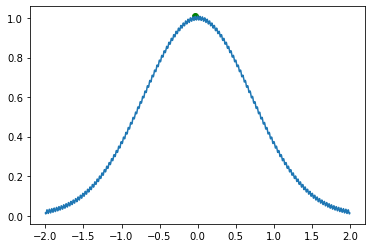

In [86]:
x = np.linspace(-2, 2, 1000)
y = f(x)
plt.plot(x, y)
plt.scatter(-.031746, f(-.031746), c='g');

The graph confirms that we have a good approximate of the maximizer (with the 1-digit precision; true maximizer is $\hat{x} = 0$, and $f(\hat{x}) = 1.01$.